In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 50)

In [3]:
df = pd.read_csv('Google-Playstore.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,4.1 and up,Rafal Milek-Horodyski,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [78]:
df_copy = df.copy()

In [79]:
# Rating이 0인 행과 Rating Count가 행의 개수가 같음 -> 평점수가 0인 미평가 상태의 앱의 평점이 0으로 되어있다는 뜻
# 해당 데이터가 100만개 정도로 거의 반을 차지하므로 삭제할 수 없고, 다른 값으로 대체한다면 분석에 오류가 생길 수 있음
# 따라서 Rating_Missing 컬럼을 하나 만들어서 0인 데이터 표시해주기
df_copy['Rating_Missing'] = ((df_copy['Rating'] == 0) & (df_copy['Rating Count'] == 0)).astype(int)

In [80]:
# 1. Rating, Rating Count : 카테고리별 평균으로 대체
df_copy['Rating'] = df_copy.groupby('Category')['Rating'].transform(lambda x: x.fillna(x.mean()))
df_copy['Rating Count'] = df_copy.groupby('Category')['Rating Count'].transform(lambda x: x.fillna(x.mean()))
df_copy[['Rating', 'Rating Count']].isna().sum()

Rating          0
Rating Count    0
dtype: int64

In [81]:
# 2. Installs, Minimum Installs : Maximum Installs 값을 이용해 결측치 대체

# Installs 범주를 숫자값으로 매핑
installs_to_min = {
    '0+': 0, '1+': 1, '5+': 5, '10+': 10, '50+': 50, '100+': 100, '500+': 500,
    '1,000+': 1000, '5,000+': 5000, '10,000+': 10000, '50,000+': 50000,
    '100,000+': 100000, '500,000+': 500000, '1,000,000+': 1000000,
    '5,000,000+': 5000000, '10,000,000+': 10000000, '50,000,000+': 50000000,
    '100,000,000+': 100000000, '500,000,000+': 500000000,
    '1,000,000,000+': 1000000000, '5,000,000,000+': 5000000000,
    '10,000,000,000+': 10000000000
}

# 1. Installs 값이 결측인 경우, Maximum Installs 기준으로 적절한 Installs 범주 추정
def estimate_installs_from_max(max_val):
    if pd.isna(max_val):
        return np.nan
    for threshold, label in installs_to_min.items():
        if max_val < label:
            return threshold
        prev_label = threshold
    return '10,000,000,000+'

# 2. Minimum Installs 채우는 함수 (우선순위: 기존 값 → Installs 매핑 → NaN)
def fill_min_installs(row):
    if pd.notna(row['Minimum Installs']):
        return row['Minimum Installs']
    elif pd.notna(row['Installs']) and (row['Installs'] in installs_to_min):
        return installs_to_min[row['Installs']]
    else:
        return np.nan

# ---------- 적용 ----------
# 원본 데이터프레임 df를 가정
# 1단계: Installs 결측치 보간 (Maximum Installs 사용)
df_copy['Installs'] = df_copy['Installs'].fillna(df_copy['Maximum Installs'].apply(estimate_installs_from_max))

# 2단계: Minimum Installs 결측치 보간 (Installs 매핑)
df_copy['Minimum Installs'] = df_copy.apply(fill_min_installs, axis=1)
df_copy.isna().sum()

App Name                  5
App Id                    0
Category                  0
Rating                    0
Rating Count              0
Installs                  0
Minimum Installs          0
Maximum Installs          0
Free                      0
Price                     0
Currency                135
Size                    196
Minimum Android        6530
Developer Id             33
Developer Website    760835
Developer Email          31
Released              71053
Last Updated              0
Content Rating            0
Privacy Policy       420953
Ad Supported              0
In App Purchases          0
Editors Choice            0
Scraped Time              0
Rating_Missing            0
dtype: int64

In [82]:
df_copy.isna().sum()

App Name                  5
App Id                    0
Category                  0
Rating                    0
Rating Count              0
Installs                  0
Minimum Installs          0
Maximum Installs          0
Free                      0
Price                     0
Currency                135
Size                    196
Minimum Android        6530
Developer Id             33
Developer Website    760835
Developer Email          31
Released              71053
Last Updated              0
Content Rating            0
Privacy Policy       420953
Ad Supported              0
In App Purchases          0
Editors Choice            0
Scraped Time              0
Rating_Missing            0
dtype: int64

In [83]:
# 3. Minimum Android, Privacy Policy, Size, Developer Id, Developer Website : drop
df_copy = df_copy.drop(['Privacy Policy'], axis=1)
df_copy.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Rating_Missing
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,False,False,False,2021-06-15 20:19:35,1
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,True,False,False,2021-06-15 20:19:35,0
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,False,False,False,2021-06-15 20:19:35,1
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False,False,2021-06-15 20:19:35,0
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,4.1 and up,Rafal Milek-Horodyski,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,False,False,False,2021-06-15 20:19:35,1


In [84]:
# 4. Currency : 최빈값인 USD로 대체
df_copy['Currency'] = df_copy['Currency'].fillna('USD')
df_copy['Currency'].isna().sum()

0

In [85]:
# 5. Released, App Name, Developer Email : 결측치가 있는 행 제거
df_copy = df_copy.dropna(subset=['Released', 'App Name', 'Developer Email']).reset_index(drop=True)
df_copy

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Rating_Missing
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,False,False,False,2021-06-15 20:19:35,1
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,True,False,False,2021-06-15 20:19:35,0
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,False,False,False,2021-06-15 20:19:35,1
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False,False,2021-06-15 20:19:35,0
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,4.1 and up,Rafal Milek-Horodyski,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,False,False,False,2021-06-15 20:19:35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241856,Lero TOEFL Recorder + Timer,com.toefltimer,Education,3.4,17.0,"1,000+",1000.0,1980,True,0.0,USD,10M,4.1 and up,Julio Augusto Vera,https://lerodoe.wordpress.com/,lero.doe@gmail.com,"May 22, 2018","Dec 14, 2018",Everyone,True,False,False,2021-06-16 12:59:18,0
2241857,ORU Online,com.threedream.oruonline,Education,0.0,0.0,100+,100.0,430,True,0.0,USD,44M,4.1 and up,"3Dream Studios, LLC",http://www.oru.edu/,3DreamDeveloper@gmail.com,"Jan 17, 2018","Feb 02, 2018",Everyone,False,False,False,2021-06-16 12:59:19,1
2241858,Data Structure,datastructure.appoworld.datastucture,Education,0.0,0.0,100+,100.0,202,True,0.0,USD,29M,5.0 and up,appoworld,NaN,appoworld.official@gmail.com,"Aug 19, 2018","Aug 19, 2018",Everyone,False,False,False,2021-06-16 12:59:19,1
2241859,Devi Suktam,ishan.devi.suktam,Music & Audio,3.5,8.0,"1,000+",1000.0,2635,True,0.0,USD,10M,5.0 and up,Bhakti,https://a70f78905.app-ads-txt.com,ruchisono@gmail.com,"Aug 1, 2016","May 05, 2021",Everyone,True,False,False,2021-06-16 12:59:19,0


In [87]:
# Size 전처리
# '10M', '3.4k' → KB 단위로 통일하여 숫자로 변환
# 'Varies with device'는 NaN으로 처리
# 문자열을 숫자형 KB로 바꾸는 함수
# replace() 함수로 M, k 같은 단위를 제거하고, 숫자로 변환한 후
# 메가(M)는 1024를 곱해 KB로 통일
# KB로 바꾼 값을 보기 좋게 다시 MB로 변환

# 문자열 → KB 단위 숫자로 변환하는 함수
def convert_size_to_mb(size_str):
    if pd.isna(size_str):
        return np.nan
    size_str = size_str.replace(',', '').strip().lower()

    if 'g' in size_str:
        return float(size_str.replace('g', '')) * 1024  # GB → MB
    elif 'm' in size_str:
        return float(size_str.replace('m', ''))         # MB 그대로
    elif 'k' in size_str:
        return float(size_str.replace('k', '')) / 1024  # KB → MB
    else:
        return np.nan  # 'Varies with device' 등 처리 불가 항목

# MB로 변환
df_copy['Size_MB'] = df_copy['Size'].apply(convert_size_to_mb)

# 'Varies with device'는 NaN으로 대체
df_copy['Size_KB'] = df_copy['Size'].replace('Varies with device', np.nan)

# 확인용 출력
print("변환 결과 예시:")
print(df_copy[['Size', 'Size_MB']].head())


변환 결과 예시:
   Size  Size_MB
0   10M     10.0
1  2.9M      2.9
2  3.7M      3.7
3  1.8M      1.8
4  6.2M      6.2


In [89]:
df_copy = df_copy.dropna(subset=['Size_MB']).reset_index(drop=True)
df_copy

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Rating_Missing,Size_KB,Size_MB
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,False,False,False,2021-06-15 20:19:35,1,10M,10.0
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,True,False,False,2021-06-15 20:19:35,0,2.9M,2.9
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,False,False,False,2021-06-15 20:19:35,1,3.7M,3.7
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False,False,2021-06-15 20:19:35,0,1.8M,1.8
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,4.1 and up,Rafal Milek-Horodyski,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,False,False,False,2021-06-15 20:19:35,1,6.2M,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190610,Lero TOEFL Recorder + Timer,com.toefltimer,Education,3.4,17.0,"1,000+",1000.0,1980,True,0.0,USD,10M,4.1 and up,Julio Augusto Vera,https://lerodoe.wordpress.com/,lero.doe@gmail.com,"May 22, 2018","Dec 14, 2018",Everyone,True,False,False,2021-06-16 12:59:18,0,10M,10.0
2190611,ORU Online,com.threedream.oruonline,Education,0.0,0.0,100+,100.0,430,True,0.0,USD,44M,4.1 and up,"3Dream Studios, LLC",http://www.oru.edu/,3DreamDeveloper@gmail.com,"Jan 17, 2018","Feb 02, 2018",Everyone,False,False,False,2021-06-16 12:59:19,1,44M,44.0
2190612,Data Structure,datastructure.appoworld.datastucture,Education,0.0,0.0,100+,100.0,202,True,0.0,USD,29M,5.0 and up,appoworld,NaN,appoworld.official@gmail.com,"Aug 19, 2018","Aug 19, 2018",Everyone,False,False,False,2021-06-16 12:59:19,1,29M,29.0
2190613,Devi Suktam,ishan.devi.suktam,Music & Audio,3.5,8.0,"1,000+",1000.0,2635,True,0.0,USD,10M,5.0 and up,Bhakti,https://a70f78905.app-ads-txt.com,ruchisono@gmail.com,"Aug 1, 2016","May 05, 2021",Everyone,True,False,False,2021-06-16 12:59:19,0,10M,10.0


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 폰트 경로 불러오기
import matplotlib.font_manager as fm
font_path = fm.findfont("Malgun Gothic")

# 폰트 설정 강제 지정
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


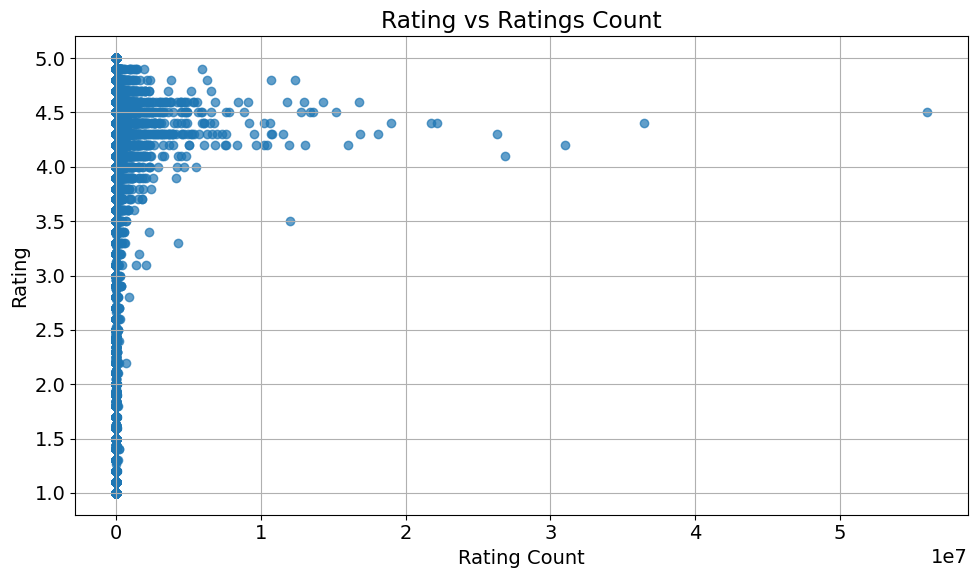

In [91]:
# 평점과 평점 수 관계 산점도 그리기
# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(exist_rating['Rating Count'], exist_rating['Rating'], alpha=0.7)
plt.title('Rating vs Ratings Count')
plt.xlabel('Rating Count')
plt.ylabel('Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


### 평점 수가 높은 앱은 평점이 높은 경우가 대부분임
# 앱 평가를 한 사람이 많은 앱은 대부분 높은 평점을 받았음

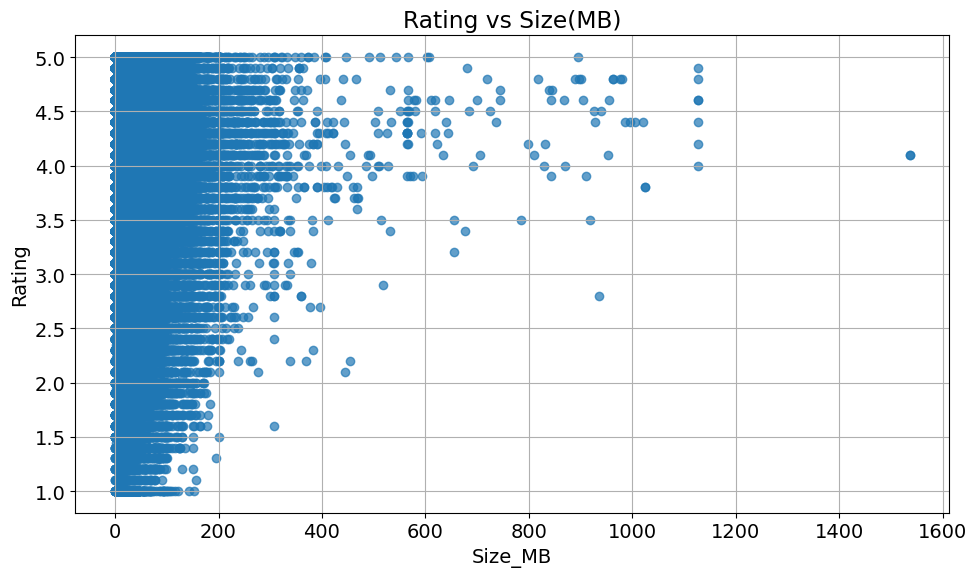

In [93]:
# 평점과 앱 크기 산점도 그리기

# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(exist_rating['Size_MB'], exist_rating['Rating'], alpha=0.7)
plt.title('Rating vs Size(MB)')
plt.xlabel('Size_MB')
plt.ylabel('Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


### 앱 사이즈가 큰 앱일 수록 평점이 높은 경우가 많음
# -> Size가 높으면 앱의 퀄리티가 상대적으로 높은게 많을 것 -> 그래서 평점 높은 앱에 사이즈가 큰 앱들이 분포해있는 것은 아닐까?

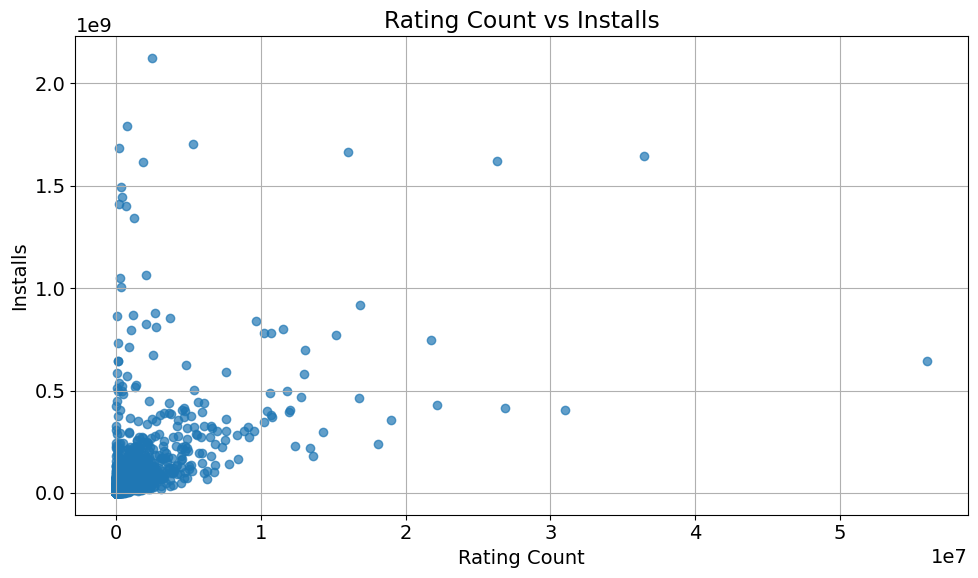

In [94]:
# 설치수와 평점수 관계

# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(exist_rating['Rating Count'], exist_rating['Maximum Installs'], alpha=0.7)
plt.title('Rating Count vs Installs')
plt.xlabel('Rating Count')
plt.ylabel('Installs')
plt.grid(True)
plt.tight_layout()
plt.show()

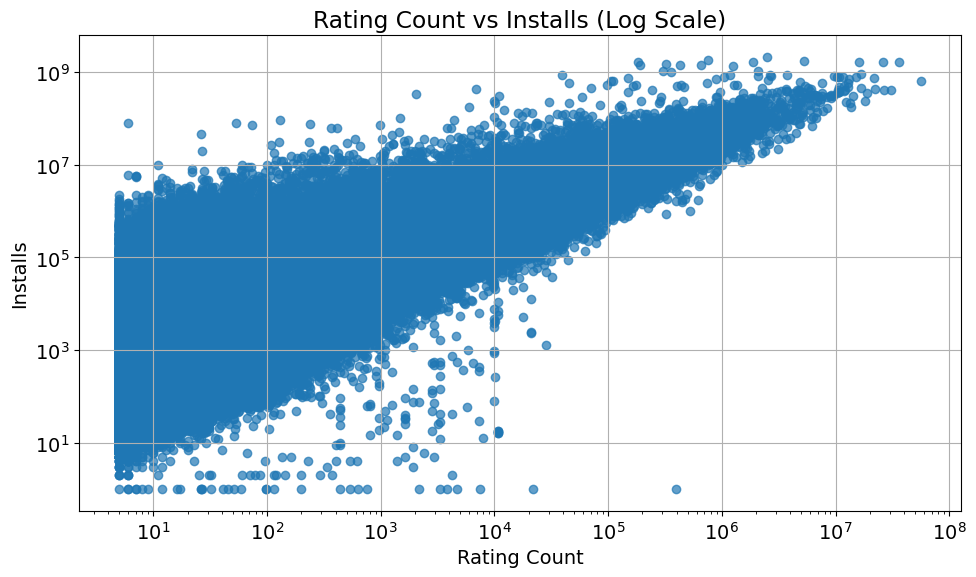

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(df_copy['Rating Count'], df_copy['Maximum Installs'], alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Rating Count vs Installs (Log Scale)')
plt.xlabel('Rating Count')
plt.ylabel('Installs')
plt.grid(True)
plt.tight_layout()
plt.show()

# 우상향하는 모습의 선형성을 보이므로, 설치수와 평점수는 양의 상관관계가 있음을 알 수 있음
# 설치수가 높은 앱일수록 평점 수가 높다

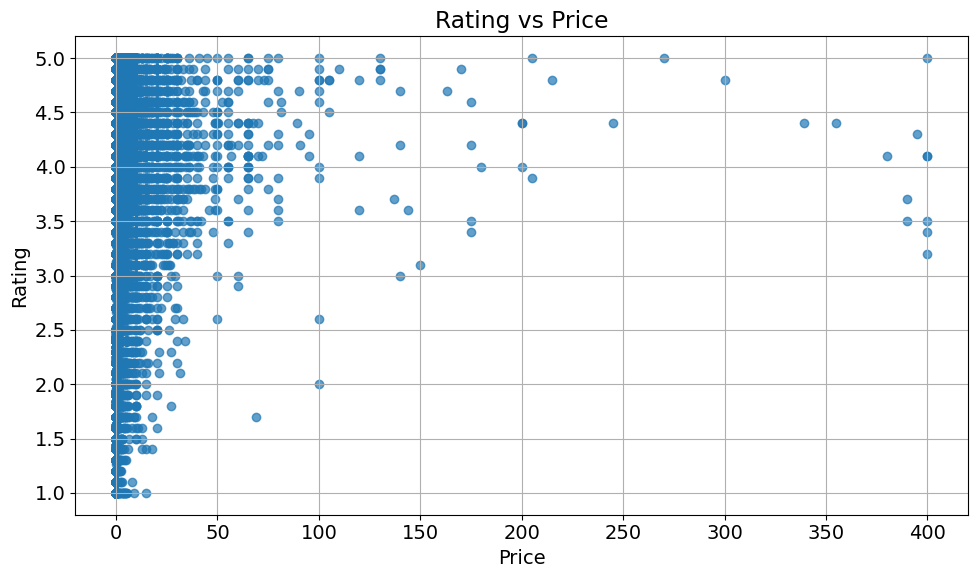

In [96]:
# 가격과 평점 관계
df_charged = df_copy[(df_copy['Rating_Missing'] == 0)]

plt.figure(figsize=(10, 6))
plt.scatter(df_charged['Price'], df_charged['Rating'], alpha=0.7)
plt.title('Rating vs Price')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

# 무료인 앱이 유료인 앱보다 훨씬 많기 때문에 유료인 경우에서만 비교 진행
# 대부분 낮은 가격에 값이 분포되어 있으나, 평점이 높은 앱 중에는 가격이 높은 앱들이 있음
# -> 이것도 사이즈와 마찬가지로 가격대가 높은 앱이면 상대적으로 퀄리티가 높을 것이므로 평점이 높을 것이라 추측할 수 있음

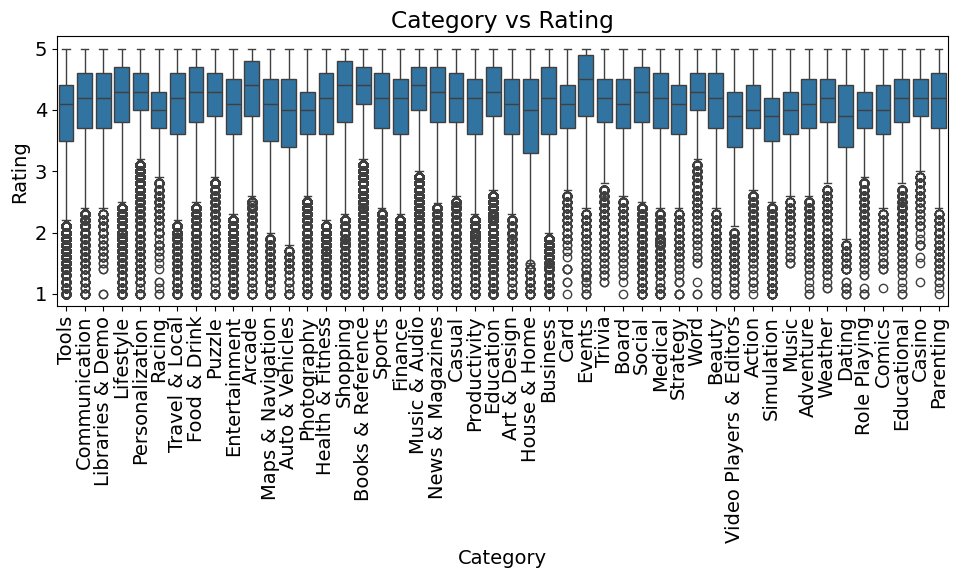

In [97]:
# 카테고리와 평점 관계

# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

plt.figure(figsize=(10, 6))
sns.boxplot(data=exist_rating, x='Category', y='Rating')
plt.title('Category vs Rating')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)  # 카테고리명이 많을 경우 회전
plt.tight_layout()
plt.show()
# Arcade, Music & Audio, Events의 중앙값이 높기 때문에 평균적으로 높은 평점을 받음을 알 수 있음
# 분포 폭이 넓은 Tools, Auto & Vehicles, House & Home 등의 카테고리는 상대적으로 평점 편차가 큼 

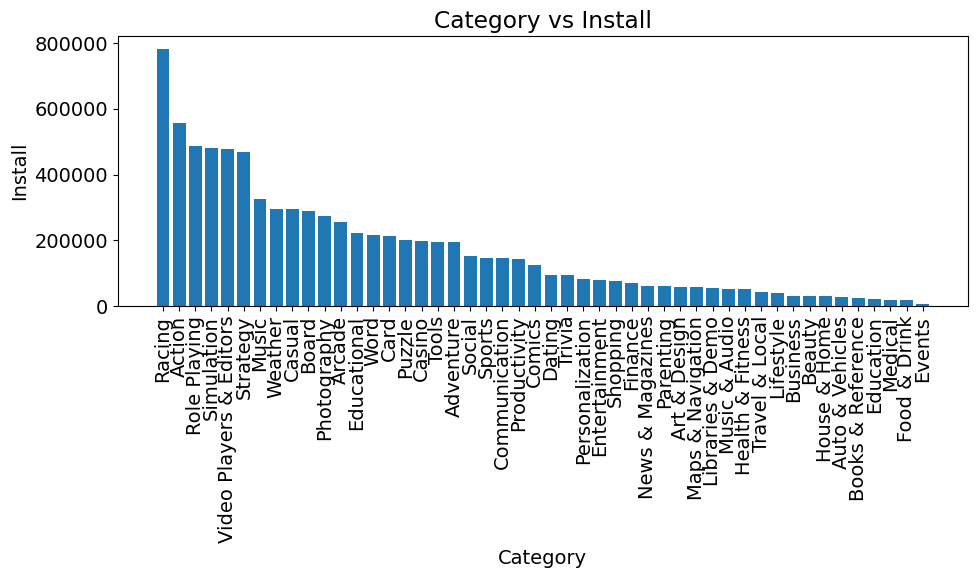

In [98]:
# 카테고리와 설치수
# 1. 카테고리별 평균 설치수 계산
category_installs = df_copy.groupby('Category')['Minimum Installs'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(category_installs.index, category_installs.values)
plt.title('Category vs Install')
plt.xlabel('Category')
plt.ylabel('Install')
plt.xticks(rotation=90)  # 카테고리명이 많을 경우 회전
plt.tight_layout()
plt.show()

# 카테고리별 평점에서 높은 평점 분포를 보였던 카테고리들이 설치수 상위권에 위치해있고, 낮은 평점 분포를 보였던 카테고리들은 설치수 하위권에 위치함

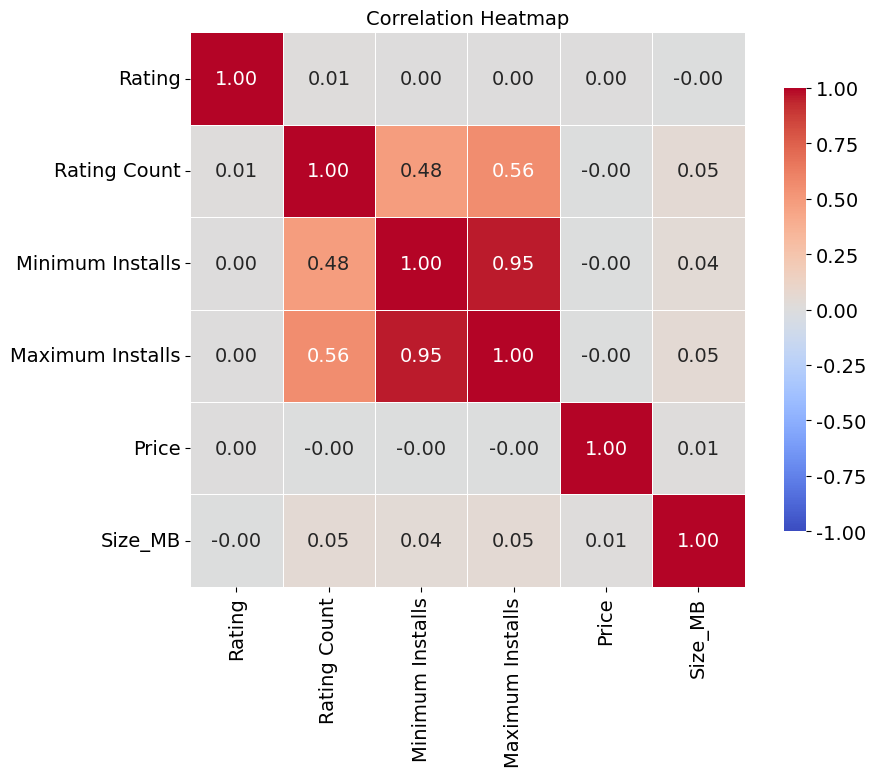

In [99]:
# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

corr_matrix = exist_rating.select_dtypes(include='number').drop('Rating_Missing', axis=1).corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # 각 칸에 숫자 표시
    fmt=".2f",            # 소수점 2자리
    cmap='coolwarm',      # 색상 스타일
    vmin=-1, vmax=1,      # 상관계수 범위 고정
    square=True,          # 정사각형 모양 칸
    linewidths=0.5,       # 셀 사이 경계선
    cbar_kws={"shrink": .8}  # 컬러바 크기 조절
)
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

# 설치수와 평점 수 간에 가장 강한 상관관계를 보임.
# 가격은 다른 컬럼들과 상관관계가 거의 약한 것을 볼 수 있음
# 사이즈와는 평점과 가장 약한 상관관계를 가진 것을 볼 수 있음

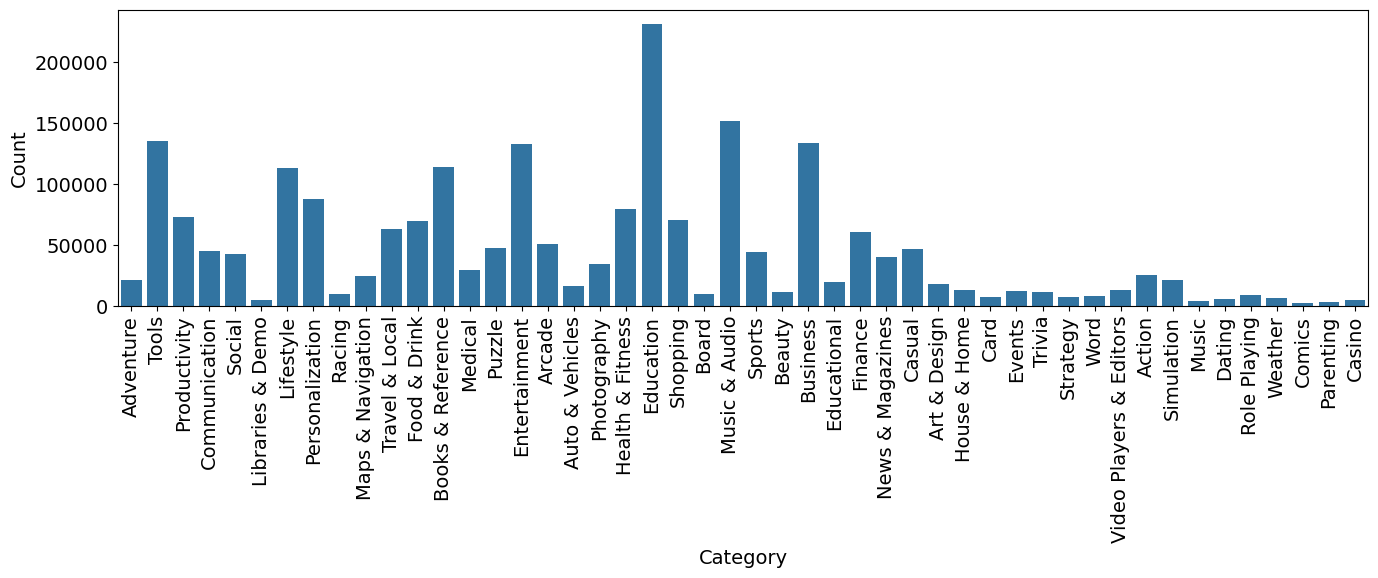

In [100]:
# 카테고리 분포 시각화
plt.figure(figsize=(14, 6))
sns.countplot(data=df_copy, x='Category')
plt.xticks(rotation=90)
# plt.title('Number of Apps per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

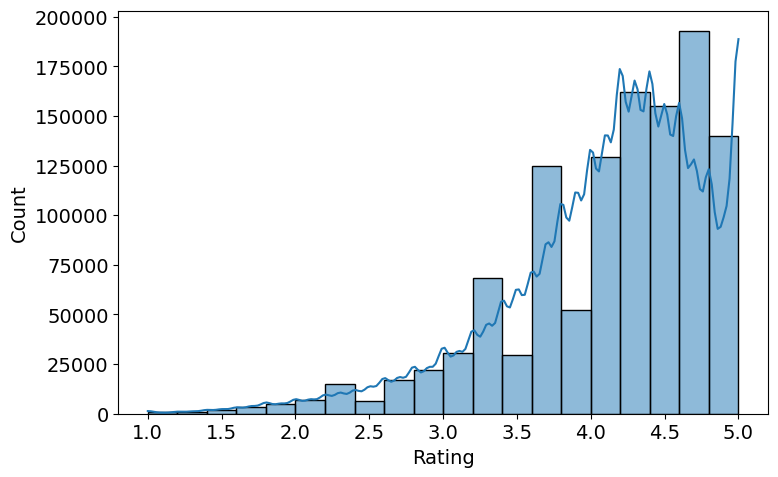

In [101]:
# 평점 분포 시각화
# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

plt.figure(figsize=(8, 5))
sns.histplot(data=exist_rating, x='Rating', bins=20, kde=True)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

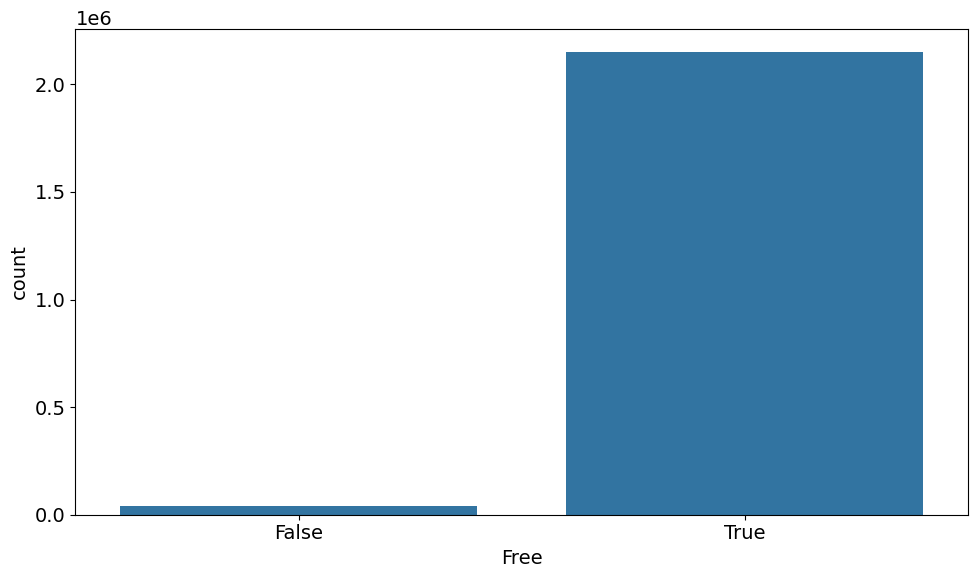

In [102]:
# 무료앱 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='Free')
plt.tight_layout()
plt.show()

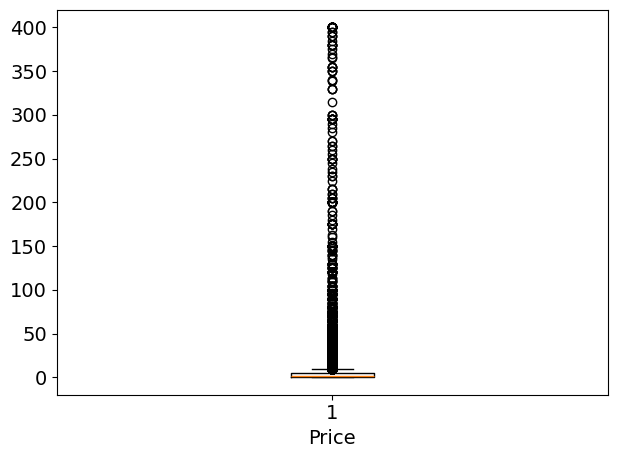

In [103]:
# 가격 분포 시각화
plt.boxplot(df_copy[df_copy['Price'] > 0]['Price'])
plt.xlabel('Price')
plt.tight_layout()
plt.show()

In [105]:
df_copy['Size_MB'].sort_values()

2161667       0.003125
102873        0.003223
288490        0.003320
132167        0.004492
109306        0.004590
              ...     
913360     1126.400000
1563214    1126.400000
1003283    1126.400000
502101     1536.000000
88414      1536.000000
Name: Size_MB, Length: 2190615, dtype: float64

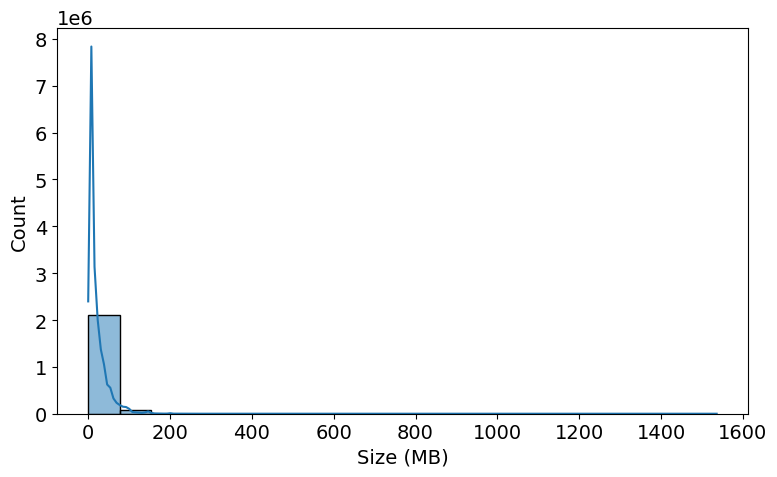

In [106]:
# 앱 크기 분포
plt.figure(figsize=(8, 5))
sns.histplot(data=df_copy, x='Size_MB', bins=20, kde=True)
plt.xlabel('Size (MB)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

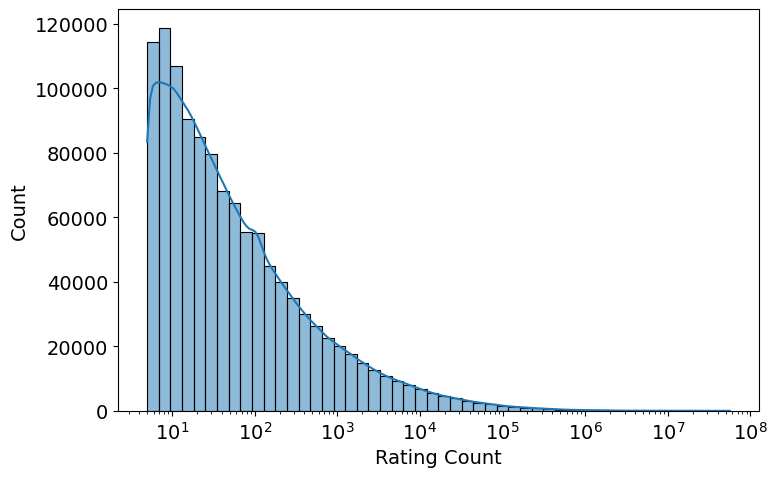

In [ ]:
# 리뷰수 분포
# Rating = 0, Rating Count = 0인 데이터는 미평가된 데이터이므로 해당 값들을 제외한 값들로 시각화
exist_rating = df_copy[df_copy['Rating_Missing'] == 0]

plt.figure(figsize=(8, 5))
sns.histplot(data=exist_rating, x='Rating Count', bins=50, kde=True, log_scale=(True, False))  # x축 로그 스케일
plt.xlabel('Rating Count')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

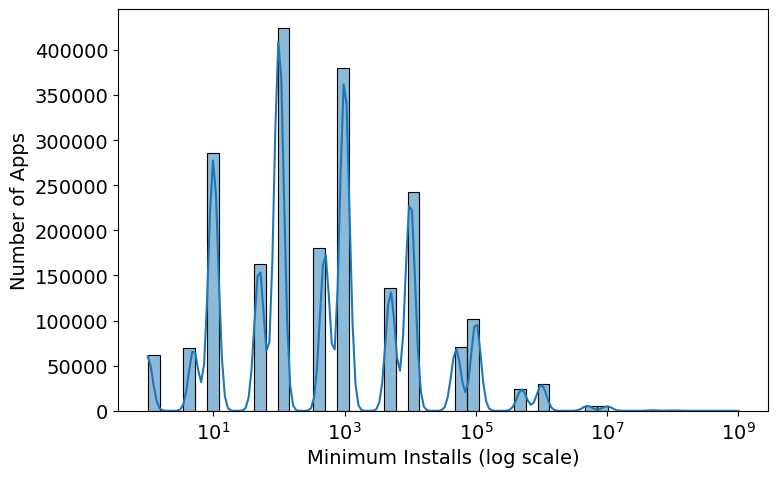

In [123]:
# 설치수 분포
# 전처리: installs가 0 이상인 앱만 필터링
df_installs = df_copy[df_copy['Minimum Installs'] > 0]

plt.figure(figsize=(8, 5))
sns.histplot(data=df_installs, x='Minimum Installs', bins=50, kde=True, log_scale=True)
plt.xlabel('Minimum Installs (log scale)')
plt.ylabel('Number of Apps')
plt.tight_layout()
plt.show()

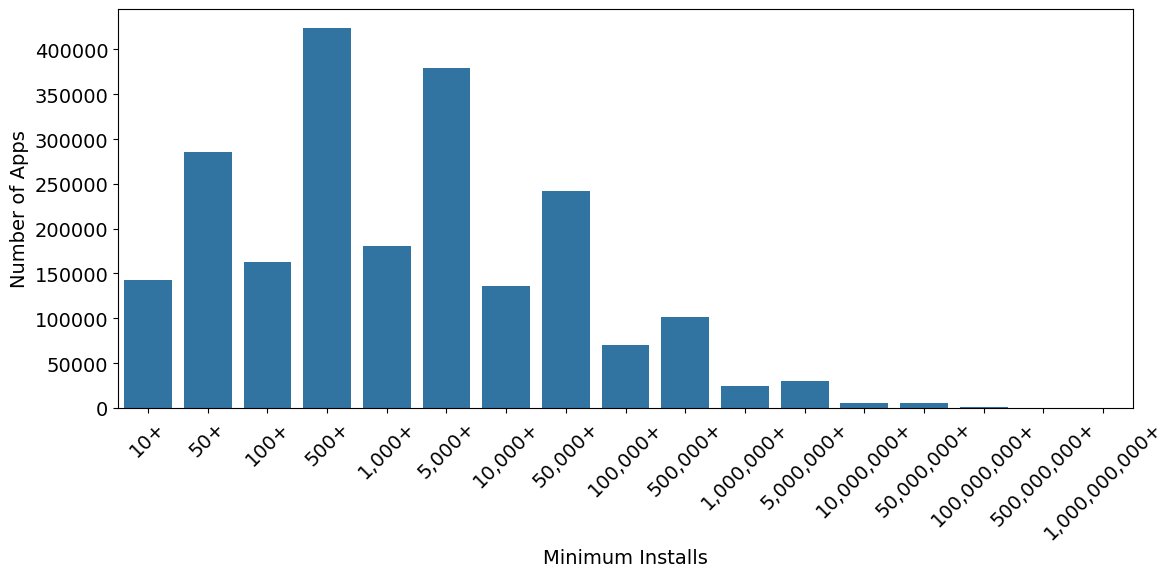

In [131]:
# 1. 문자열을 숫자로 변환
df_copy['Installs_clean'] = (
    df_copy['Installs']
    .astype(str)
    .str.replace('[+,]', '', regex=True)
    .astype(float)
)

# 2. 구간 정의
bins = [0, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000,
        500_000, 1_000_000, 5_000_000, 10_000_000, 50_000_000,
        100_000_000, 500_000_000, 1_000_000_000]
labels = [f"{int(b):,}+" for b in bins[1:]]

# 3. 구간화
df_copy['install_bin'] = pd.cut(
    df_copy['Installs_clean'],
    bins=bins,
    labels=labels,
    right=False
)

# 4. 순서 지정
df_copy['install_bin'] = pd.Categorical(
    df_copy['install_bin'],
    categories=labels,
    ordered=True
)

# 5. 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df_copy, x='install_bin', order=labels)
plt.xticks(rotation=45)
plt.xlabel('Minimum Installs')
plt.ylabel('Number of Apps')
plt.tight_layout()
plt.show()
